In [1]:
import numpy as np
import pandas as pd

data = pd.read_excel("./instrument.xlsx")
columns = data.columns.tolist()
columns

['T', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'V', 'Ax', 'Ay', 'Az', 'A']

In [2]:
def create_new_scheme(nums, file_name):
    """
    创建模拟数据
    :param nums: 创建模拟数据集的个数
    :param file_name: 原始数据集路径，xlsx格式
    """
    data = pd.read_excel(file_name)
    save_name = file_name.split(".")[0]
    i = 0
    while i < nums:
        n = np.random.randint(10)
        dd = data.copy()
        # if np.random.rand() > 0.5:
        for col in columns:
            if col == 'T':
                continue
            dd[col] = dd[col].map(lambda x:x + n * np.random.rand())
        dd.to_excel(save_name + f"instrument{i}.xlsx", index=0)
        i += 1
        
create_new_scheme(10, "./instrument.xlsx")
print("Done!")

Done!


In [3]:
import os
import glob
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
import warnings


warnings.filterwarnings('ignore')


data = []
data_files = glob.glob("./*.xlsx")
# data_tables = []
# for file in data_files:
#     data_table = pd.read_excel(file)
#     data_tables.append(data_table)
for file in data_files:
    table = pd.read_excel(file)
    table["speed"] = (table["Vx"] ** 2 + table["Vy"] ** 2 + table["Vz"] ** 2) ** 0.5
    table["acceleration"] = (table["Ax"] ** 2  + table["Ay"] ** 2 + table["Az"] ** 2) ** 0.5
    table["dx"] = table["x"].diff().fillna(0)
    table["dy"] = table["y"].diff().fillna(0)
    table["dz"] = table["z"].diff().fillna(0)
    table["displacement"] = (table["dx"] ** 2 + table["dy"] ** 2 + table["dz"] ** 2) ** 0.5
#     X = df[["T", "x", "y", "z"，"Dx", "Dy", "Dz"]].values
#     y = df[["Vx", "Vy", "Vz", "Ax", "Ay", "Az", "A", "Dx", "Dy", "Dz"]].values
    X = table[["T", "x", "y", "z"]].values
    y = table[["Vx", "Vy", "Vz", "Ax", "Ay", "Az", "A"]].values

    y_vel = y[:, :3]
    y_acc = y[:, 3:6]
#     y_disp = y[:, 6:9]
    # df.set_index("T", inplace=True)
    data.append((X, y_vel, y_acc, table))


num_tables = len(data_files)

train_data = data[:int(num_tables*0.7)]
test_data = data[int(num_tables*0.3):]

kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)  
gpr = GaussianProcessRegressor(kernel=kernel)

for i, (X_train, y_train_vel, y_train_acc, _) in enumerate(train_data):
    gpr_vel = gpr.fit(X_train, y_train_vel)
    gpr_acc = gpr.fit(X_train, y_train_acc)

  
    X_test, y_test_vel, y_test_acc, df = test_data[i]
    y_pred_vel, std_vel = gpr_vel.predict(X_test, return_std=True)
    y_pred_acc, std_acc = gpr_acc.predict(X_test, return_std=True)


#     dt = np.diff(X_test[:, 0])[:, np.newaxis]
#     delta_pos = y_pred_vel[:-1, :] * dt + 0.5 * y_pred_acc[:-1, :] * dt ** 2


#     pos_pred = np.zeros_like(y_pred_vel)
#     pos_pred[0, :] = train_data.iloc[-1, [1, 2, 3]].values + delta_pos[0, :]
#     for j in range(1, len(delta_pos)):
#         pos_pred[j, :] = pos_pred[j-1, :] + delta_pos[j, :]

#     x0 = X_test[0, 1:] 
#     y_test_displacement = X_test[:, 1:] - x0 
#     y_pred_displacement = pos_pred - x0 
#     std_displacement = np.std(y_test_displacement - y_pred_displacement)
    
    

    df["std_vel"] = std_vel
    df["std_acc"] = std_acc
#     df_test["std_displacement"] = std_displacement

    df["Vx_pred"] = y_pred_vel[:, 0]
    df["Vy_pred"] = y_pred_vel[:, 1]
    df["Vz_pred"] = y_pred_vel[:, 2]
    df["Ax_pred"] = y_pred_acc[:, 0]
    df["Ay_pred"] = y_pred_acc[:, 1]
    df["Az_pred"] = y_pred_acc[:, 2]
    print(df)
#     df_test["x_pred"] = pos_pred[:, 0]
#     df_test["y_pred"] = pos_pred[:, 1]
#     df_test["z_pred"] = pos_pred[:, 2]

#     df.to_csv(f"result_{i}.csv", index=False)

       T              x              y             z         Vx         Vy  \
0      1  440769.465628 -103442.734982  1.147019e+06  15.859443 -71.557181   
1      2  440786.749559 -103515.674883  1.146937e+06  17.911798 -72.794211   
2      3  440801.231476 -103595.669486  1.146855e+06  16.602545 -75.095754   
3      4  440816.867737 -103673.947696  1.146774e+06  17.640595 -75.936918   
4      5  440832.421754 -103749.928556  1.146693e+06  18.446050 -76.762139   
..   ...            ...            ...           ...        ...        ...   
96    97  442390.583511 -111758.390921  1.140931e+06  18.270520 -93.454699   
97    98  442406.646214 -111855.947871  1.140887e+06  18.061015 -94.279308   
98    99  442424.957989 -111950.846167  1.140845e+06  18.085704 -94.425753   
99   100  442444.663346 -112048.330289  1.140799e+06  18.003507 -94.725322   
100  101  442460.069125 -112143.520087  1.140757e+06  18.511456 -93.552588   

            Vz           V        Ax        Ay  ...         dz 

Polynomial Regression (V): MSE = 0.2651, R-squared = 0.9395


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 2.3000000000000003}
Best score: -18.243994235053464
Gaussian Process Regression (V): MSE = 0.1073, R-squared = 0.9755
Polynomial Regression (A): MSE = 0.1056, R-squared = 0.1805


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 0.1}
Best score: -0.21263723630081244
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 110.9418, R-squared = 0.0952


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -1.8309609883575633
Gaussian Process Regression (displacement): MSE = 10.9942, R-squared = 0.9103
Saving processed data to ./instrument9_processed.csv
./instrument9.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 3.6447, R-squared = 0.5162


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 3.4000000000000004}
Best score: -0.833859025107691
Gaussian Process Regression (V): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (A): MSE = 2.7981, R-squared = 0.0904


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 5.6}
Best score: -0.12749727186110146
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 116.2025, R-squared = 0.0945


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 6.7}
Best score: -0.23822171613053994
Gaussian Process Regression (displacement): MSE = 0.0196, R-squared = 0.9998
Saving processed data to ./instrument5_processed.csv
./instrument5.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.8922, R-squared = 0.8120


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 5.6}
Best score: -2.2356274458776446
Gaussian Process Regression (V): MSE = 0.7291, R-squared = 0.8463
Polynomial Regression (A): MSE = 0.7698, R-squared = 0.0861


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 2.3000000000000003}
Best score: -0.18509673694999837
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 112.8080, R-squared = 0.0917


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 10.0, 'kernel__k2__noise_level': 8.9}
Best score: -0.8704284418909406
Gaussian Process Regression (displacement): MSE = 3.0974, R-squared = 0.9751
Saving processed data to ./instrument4_processed.csv
./instrument4.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.9179, R-squared = 0.7898


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 6.7}
Best score: -3.164740720817238
Gaussian Process Regression (V): MSE = 0.6063, R-squared = 0.8611
Polynomial Regression (A): MSE = 0.7178, R-squared = 0.0838


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.03856849712529882
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 112.5344, R-squared = 0.0910


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 6.7, 'kernel__k2__noise_level': 6.7}
Best score: -1.039545957554226
Gaussian Process Regression (displacement): MSE = 0.2446, R-squared = 0.9980
Saving processed data to ./instrument8_processed.csv
./instrument8.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.5883, R-squared = 0.8710


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 5.6}
Best score: -1.789077243228554
Gaussian Process Regression (V): MSE = 0.4353, R-squared = 0.9045
Polynomial Regression (A): MSE = 0.3867, R-squared = 0.1545


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 0.1}
Best score: -0.09721192288243893
Gaussian Process Regression (A): MSE = 0.1646, R-squared = 0.6400
Polynomial Regression (displacement): MSE = 111.6073, R-squared = 0.0935


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 4.5}
Best score: -1.169058785100902
Gaussian Process Regression (displacement): MSE = 6.8334, R-squared = 0.9445
Saving processed data to ./instrument3_processed.csv
./instrument3.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.5798, R-squared = 0.8643


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 0.1, 'kernel__k2__noise_level': 6.7}
Best score: -2.6996328767235624
Gaussian Process Regression (V): MSE = 0.4718, R-squared = 0.8896
Polynomial Regression (A): MSE = 0.3497, R-squared = 0.0705


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 7.800000000000001}
Best score: -0.06323193611435127
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 111.5024, R-squared = 0.0940


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 0.1}
Best score: -1.337987066581174
Gaussian Process Regression (displacement): MSE = 9.4515, R-squared = 0.9232
Saving processed data to ./instrument2_processed.csv
./instrument2.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 4.1512, R-squared = 0.5310


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 1.2000000000000002, 'kernel__k2__noise_level': 4.5}
Best score: -0.9081902347811427
Gaussian Process Regression (V): MSE = 3.8601, R-squared = 0.5639
Polynomial Regression (A): MSE = 3.4679, R-squared = 0.0129


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 1.2000000000000002}
Best score: -0.06363077108279121
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 118.6531, R-squared = 0.0884


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 6.7, 'kernel__k2__noise_level': 8.9}
Best score: -0.3187827090683716
Gaussian Process Regression (displacement): MSE = 3.4177, R-squared = 0.9737
Saving processed data to ./instrument1_processed.csv
./instrument1.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 5.5197, R-squared = 0.5301


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 1.2000000000000002, 'kernel__k2__noise_level': 0.1}
Best score: -0.7547269614956671
Gaussian Process Regression (V): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (A): MSE = 4.2984, R-squared = 0.0817


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 8.9}
Best score: -0.20493848419408162
Gaussian Process Regression (A): MSE = 0.0001, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 123.4120, R-squared = 0.0838


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 3.4000000000000004, 'kernel__k2__noise_level': 0.1}
Best score: -0.1749571907573233
Gaussian Process Regression (displacement): MSE = 0.0000, R-squared = 1.0000
Saving processed data to ./instrument0_processed.csv
./instrument0.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.8907, R-squared = 0.8071


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 5.6}
Best score: -1.8748146605108666
Gaussian Process Regression (V): MSE = 0.7068, R-squared = 0.8469
Polynomial Regression (A): MSE = 0.7875, R-squared = 0.0513


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/skl

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 1.2000000000000002}
Best score: -0.046463716880725814
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 113.0223, R-squared = 0.0916


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 2.3000000000000003}
Best score: -1.3039914633835488
Gaussian Process Regression (displacement): MSE = 0.0494, R-squared = 0.9996
Saving processed data to ./instrument7_processed.csv
./instrument7.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 2.2598, R-squared = 0.6413


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 6.7, 'kernel__k2__noise_level': 5.6}
Best score: -0.8811726910383622
Gaussian Process Regression (V): MSE = 2.0047, R-squared = 0.6818
Polynomial Regression (A): MSE = 1.9524, R-squared = 0.0282


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 8.9, 'kernel__k2__noise_level': 6.7}
Best score: -0.04324061363952025
Gaussian Process Regression (A): MSE = 0.0000, R-squared = 1.0000
Polynomial Regression (displacement): MSE = 115.2787, R-squared = 0.0910


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sk

Best parameters: {'kernel__k1__length_scale': 7.800000000000001, 'kernel__k2__noise_level': 5.6}
Best score: -0.34490994935573666
Gaussian Process Regression (displacement): MSE = 0.2428, R-squared = 0.9981
Saving processed data to ./instrument6_processed.csv
./instrument6.xlsx Done!
----------------------------------------------------------------------------------------
Polynomial Regression (V): MSE = 0.2133, R-squared = 0.9496


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 4.5, 'kernel__k2__noise_level': 8.9}
Best score: -369.4069373601723
Gaussian Process Regression (V): MSE = 0.0170, R-squared = 0.9960
Polynomial Regression (A): MSE = 0.0360, R-squared = 0.4884


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 5.6, 'kernel__k2__noise_level': 6.7}
Best score: -3.8389590897438266
Gaussian Process Regression (A): MSE = 0.0001, R-squared = 0.9992
Polynomial Regression (displacement): MSE = 111.0637, R-squared = 0.0943


/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/prime/opt/anaconda3/lib/python3.9/site-packages/

Best parameters: {'kernel__k1__length_scale': 2.3000000000000003, 'kernel__k2__noise_level': 3.4000000000000004}
Best score: -4.535555562282681
Gaussian Process Regression (displacement): MSE = 10.5821, R-squared = 0.9137
Saving processed data to ./instrument_processed.csv
./instrument.xlsx Done!
----------------------------------------------------------------------------------------
Complete all processing steps.


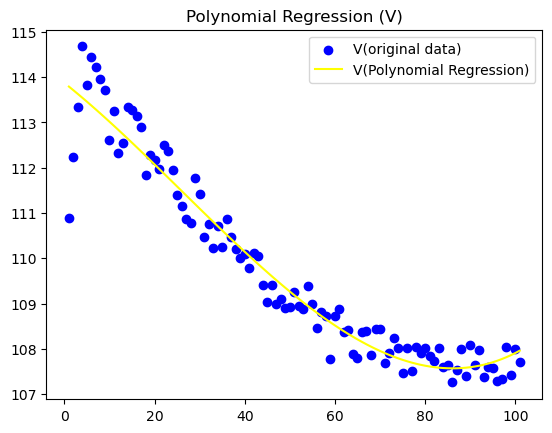

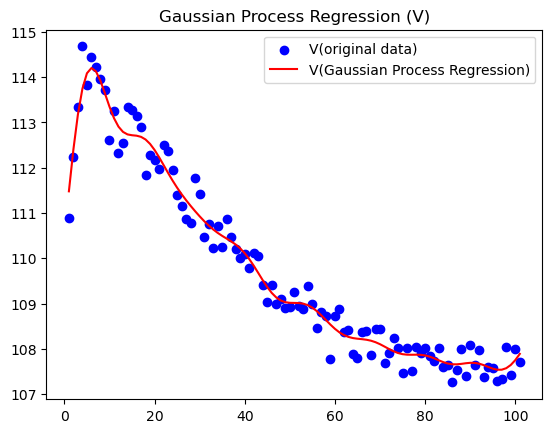

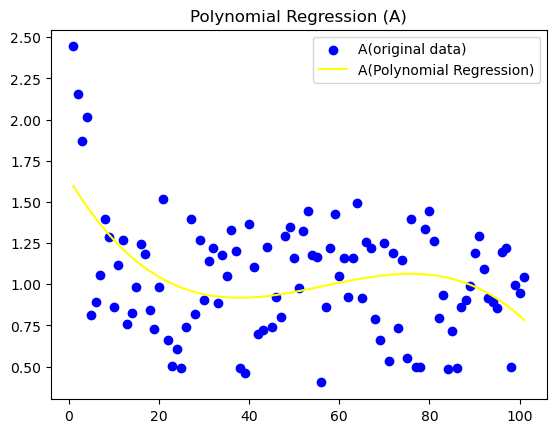

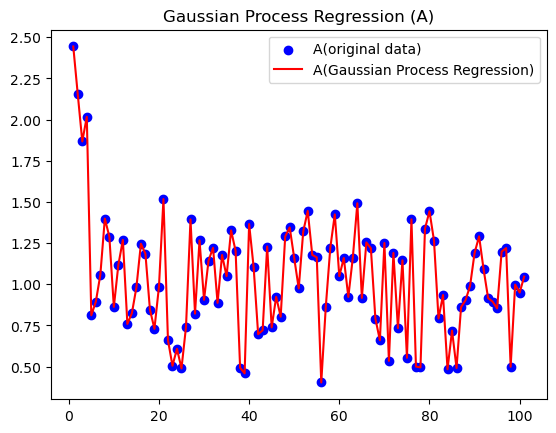

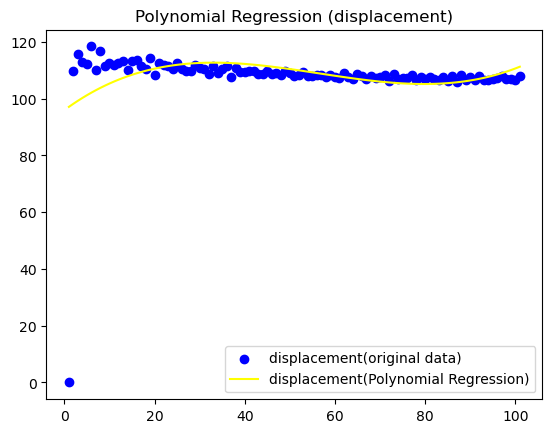

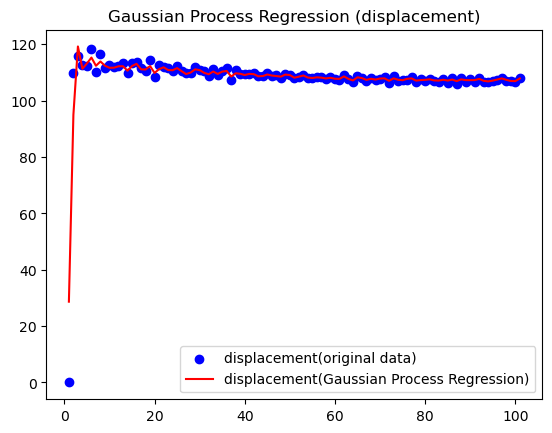

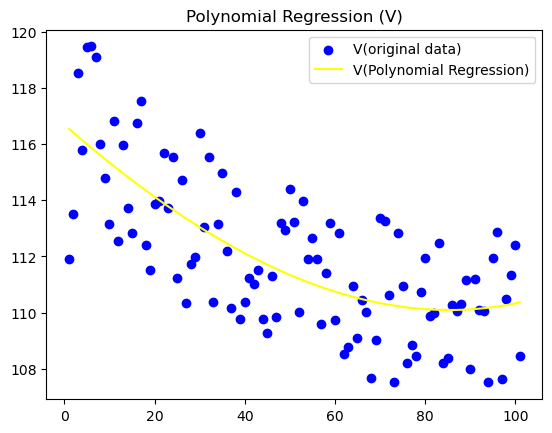

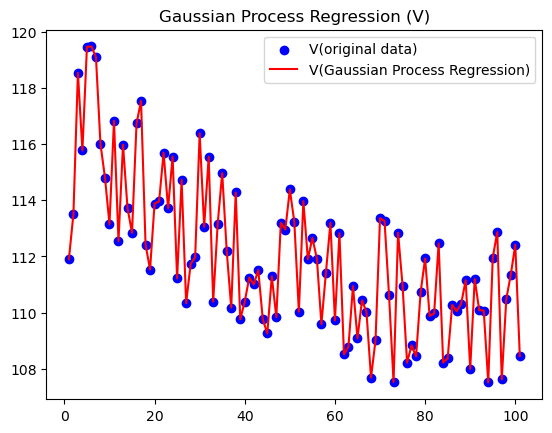

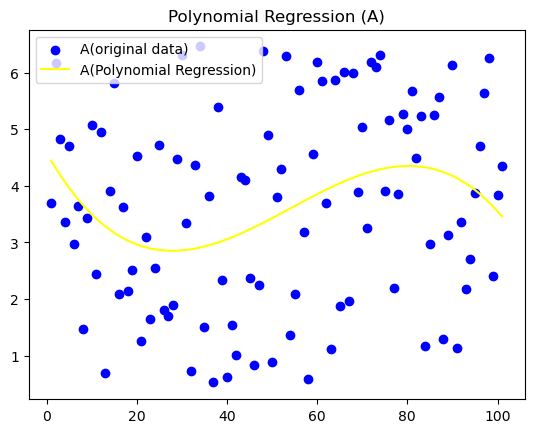

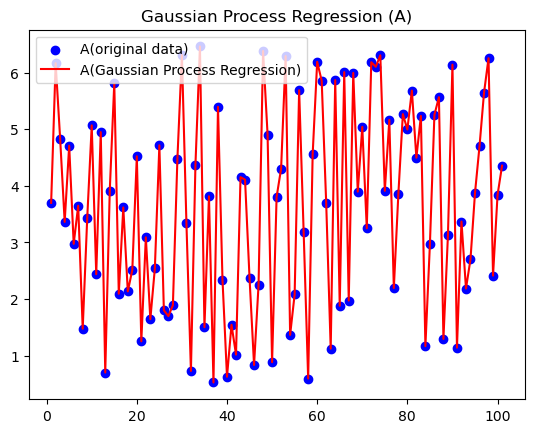

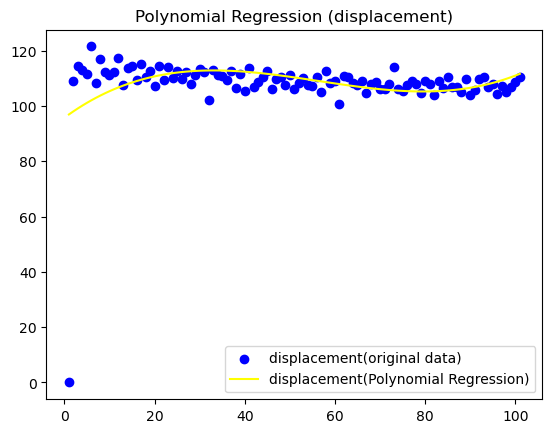

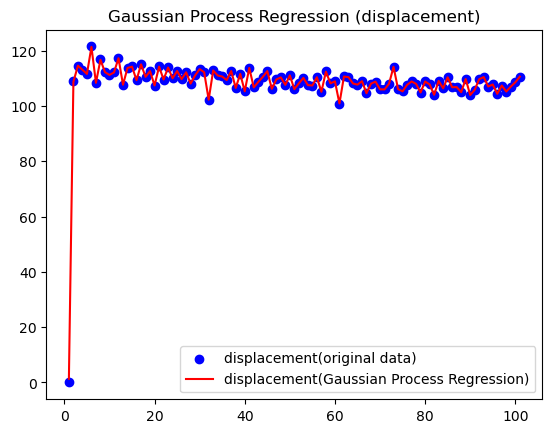

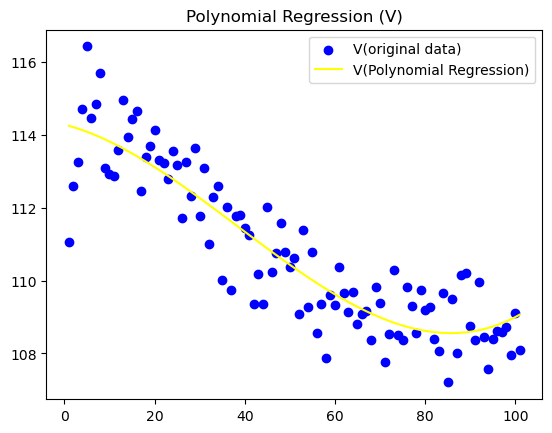

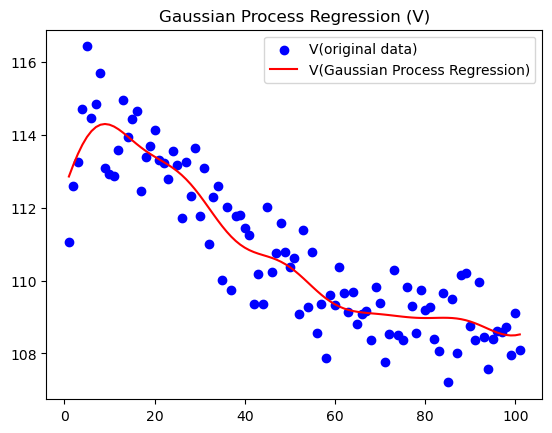

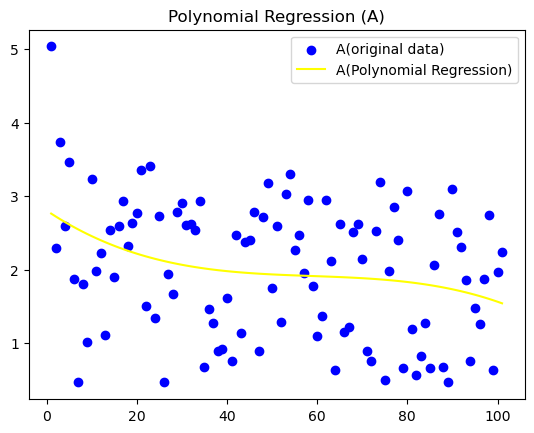

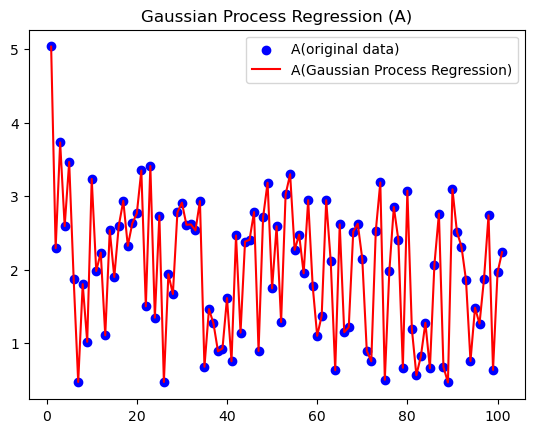

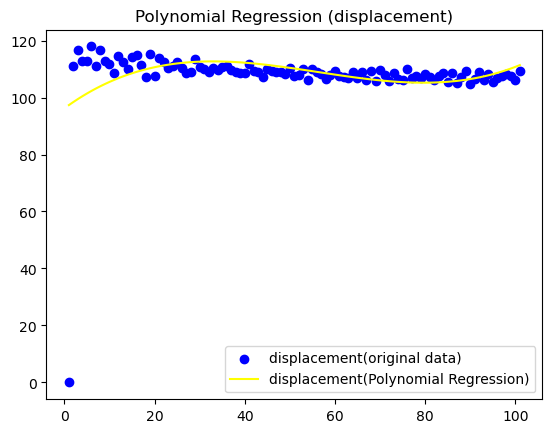

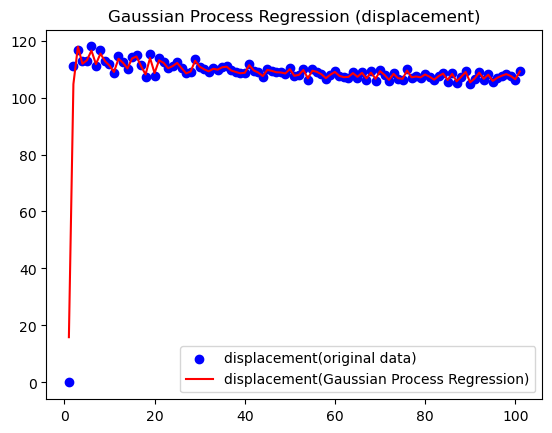

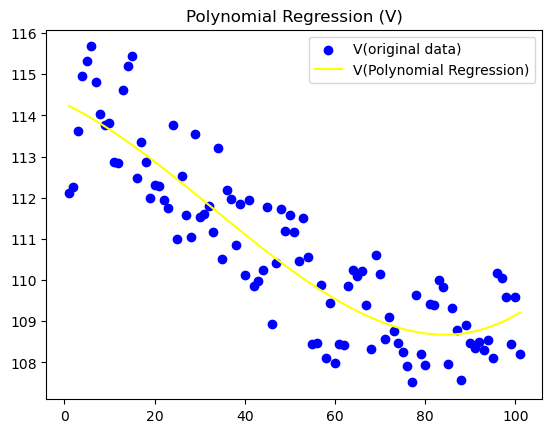

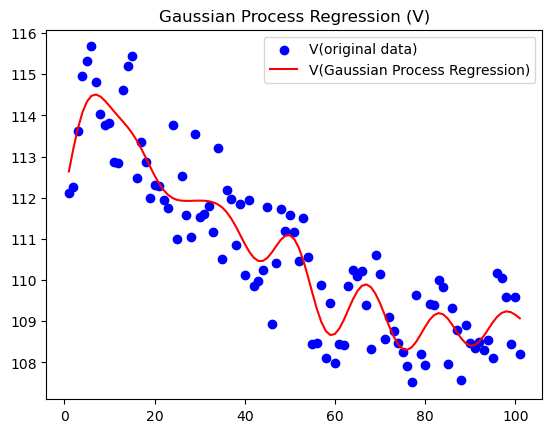

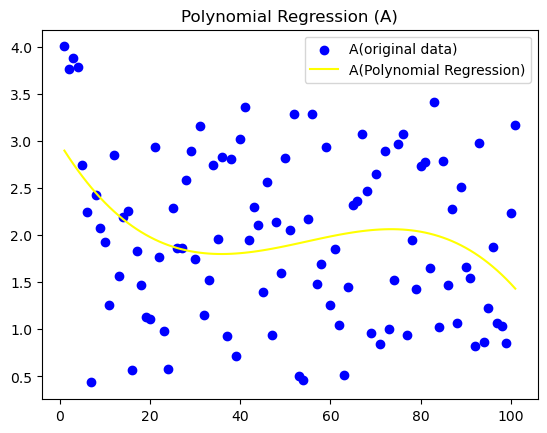

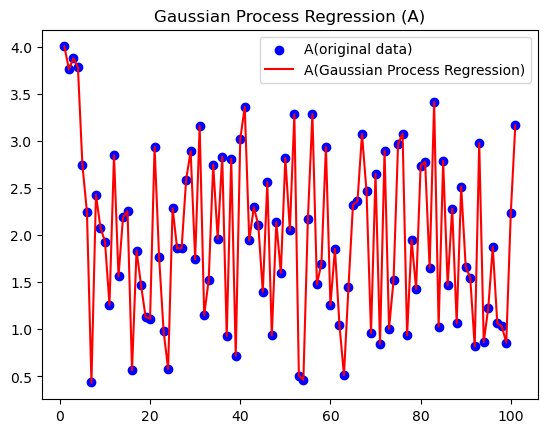

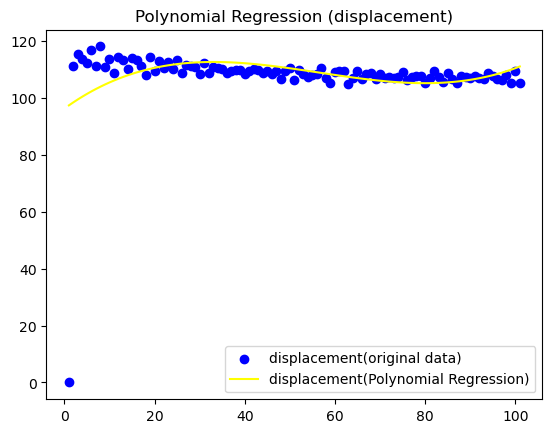

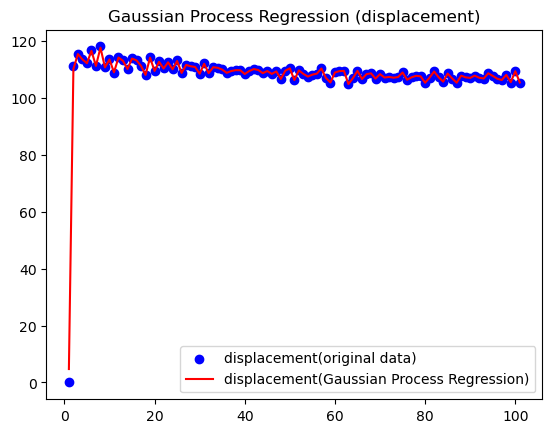

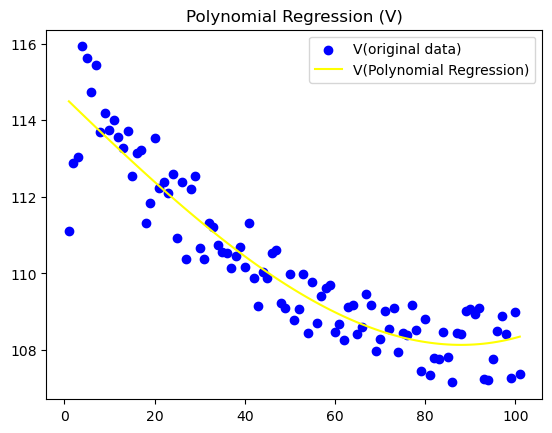

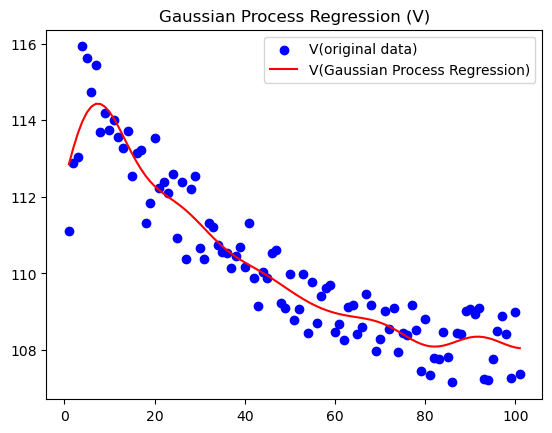

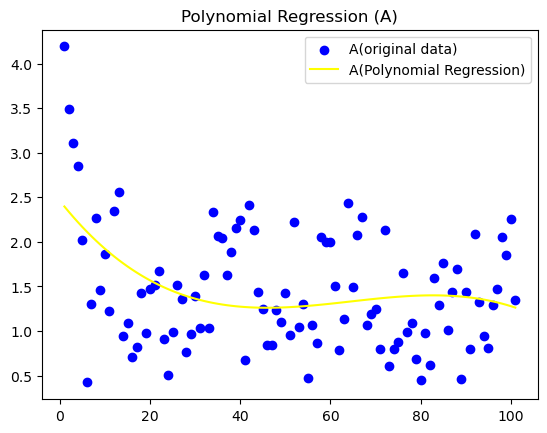

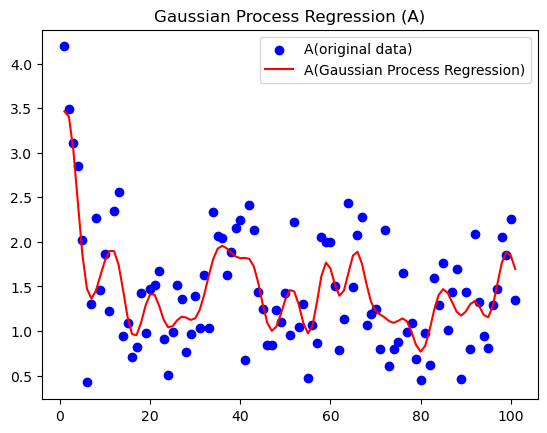

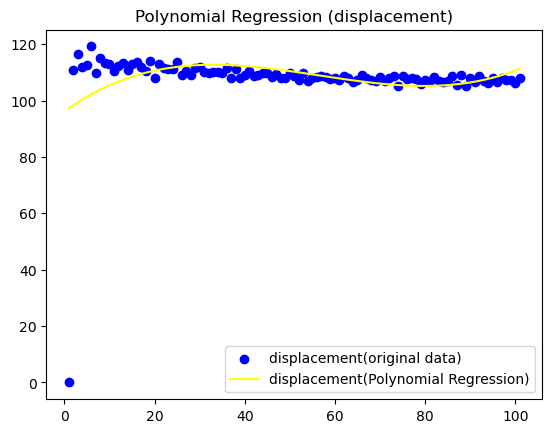

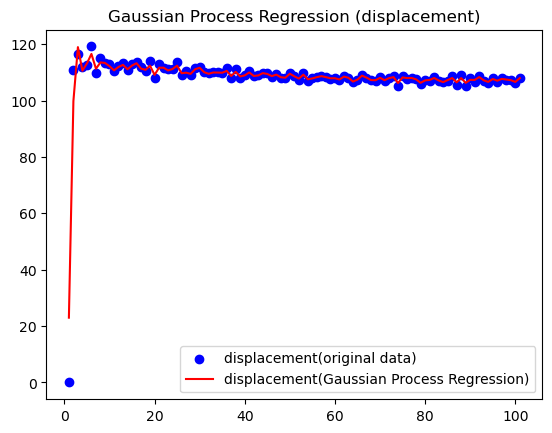

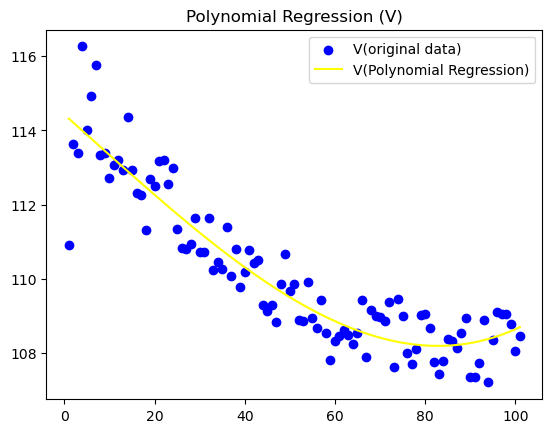

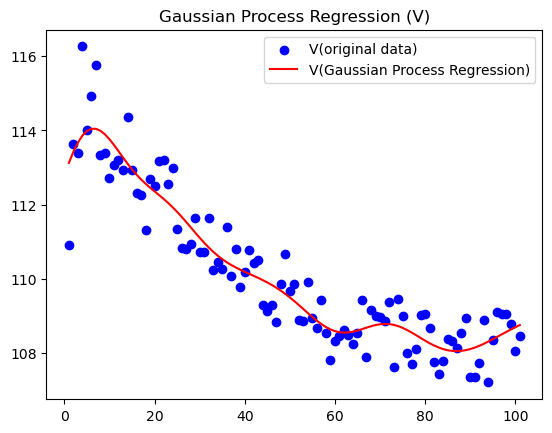

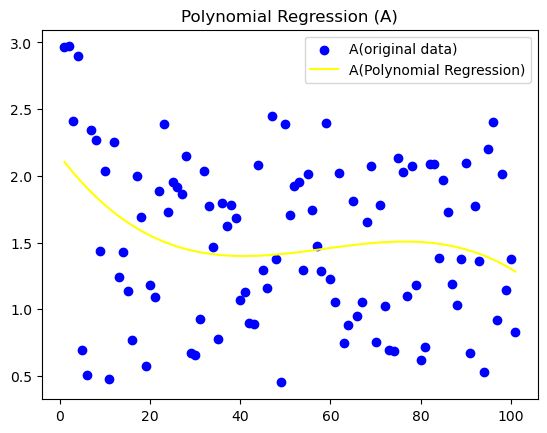

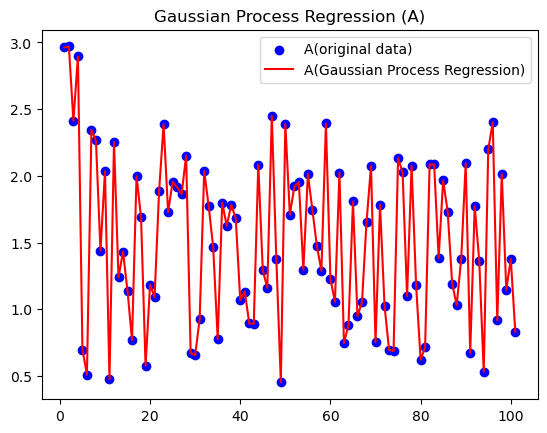

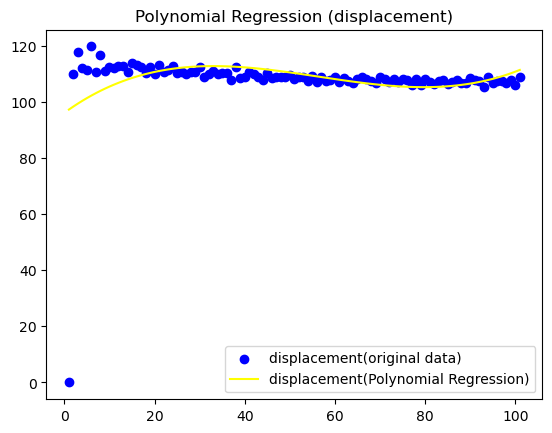

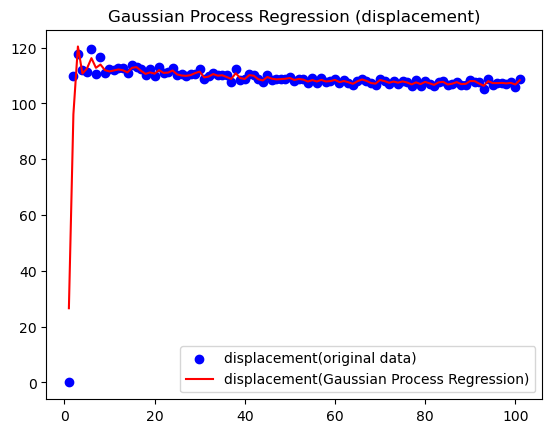

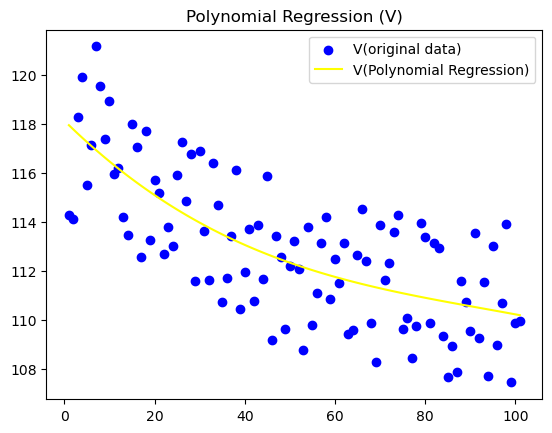

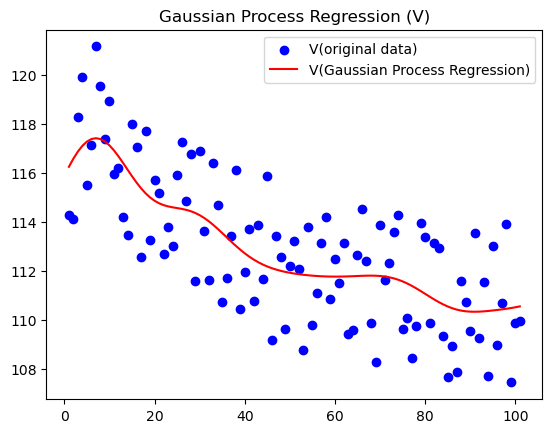

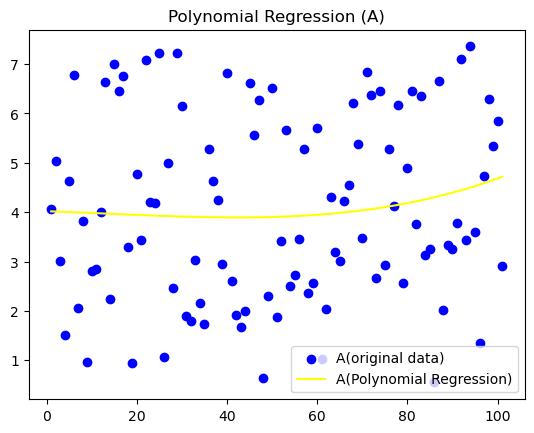

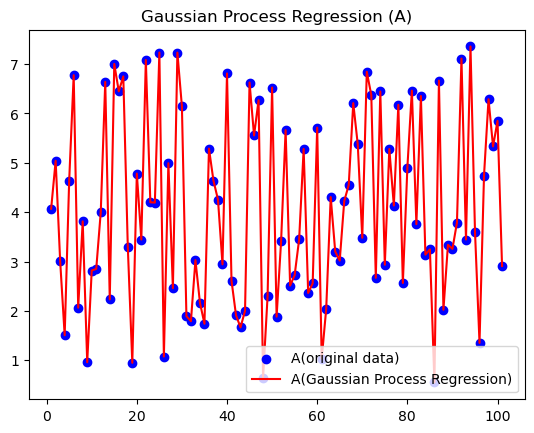

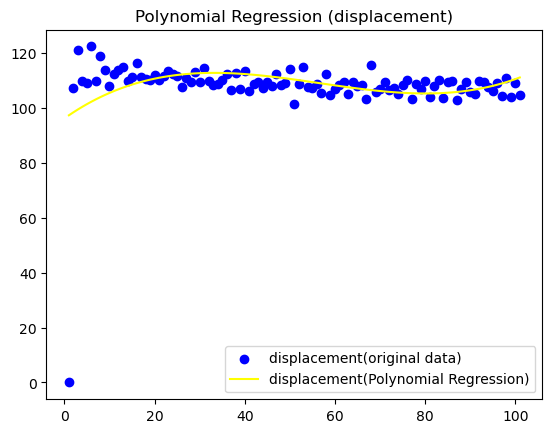

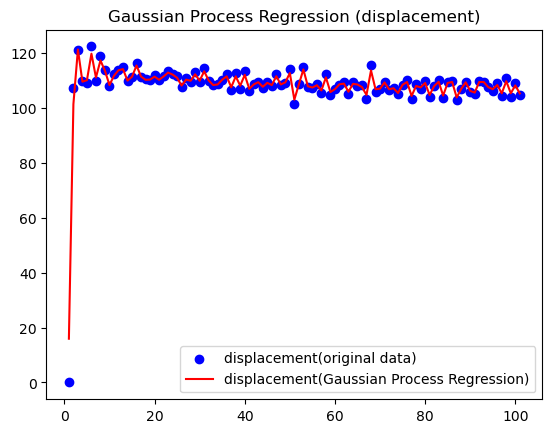

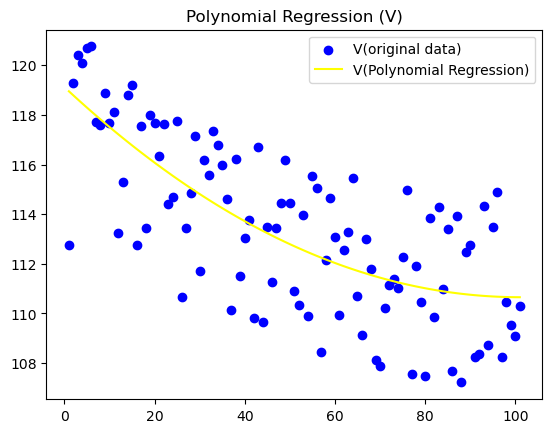

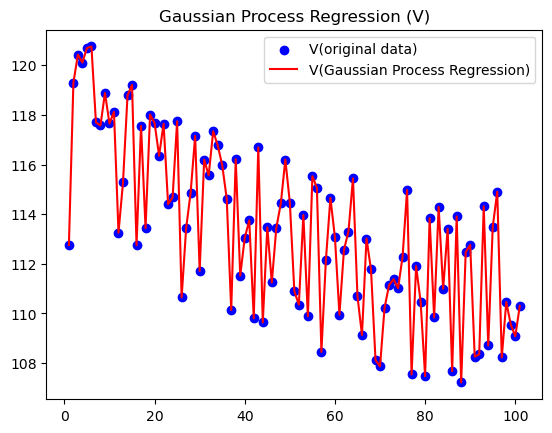

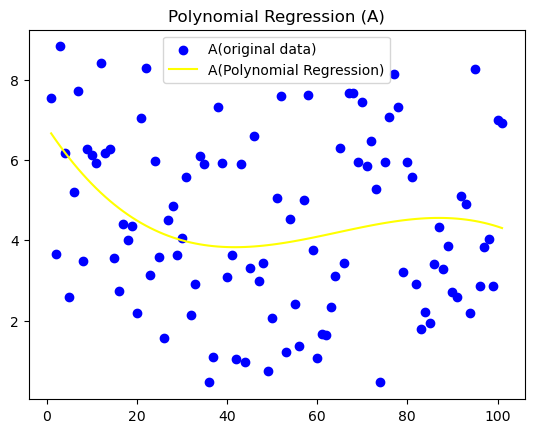

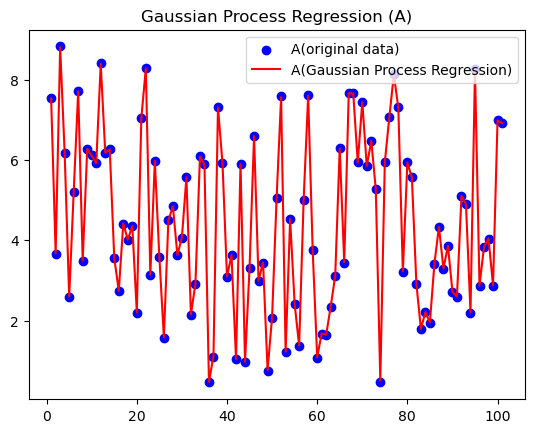

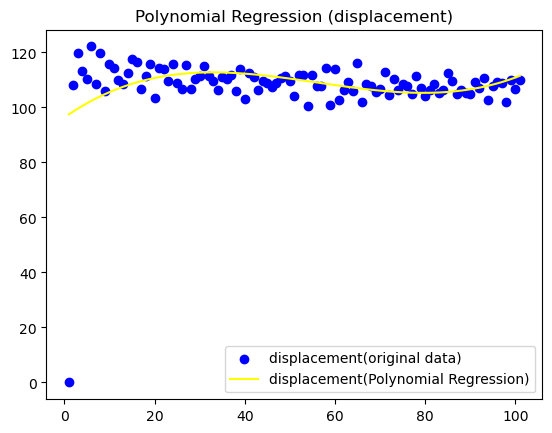

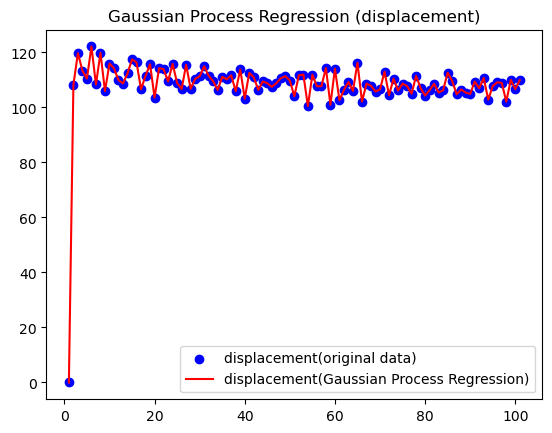

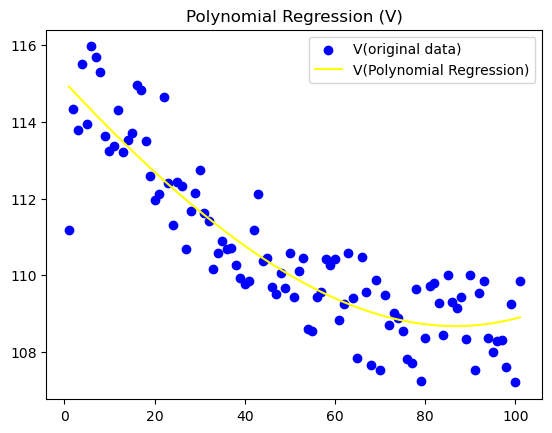

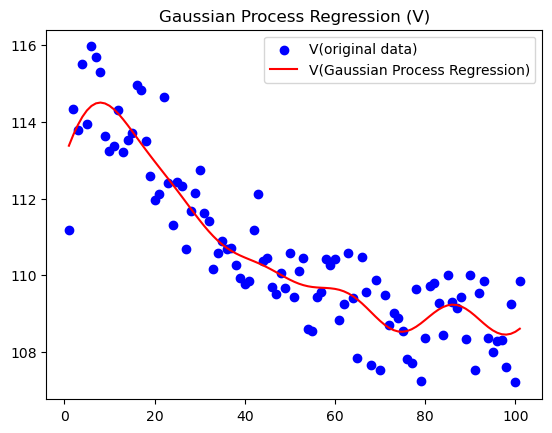

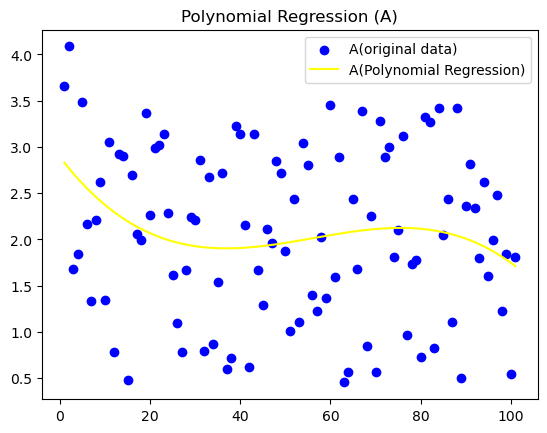

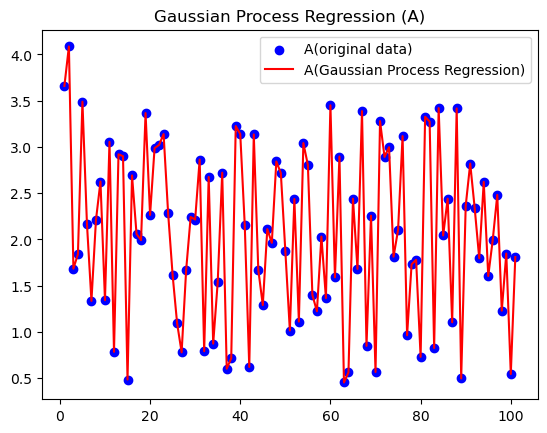

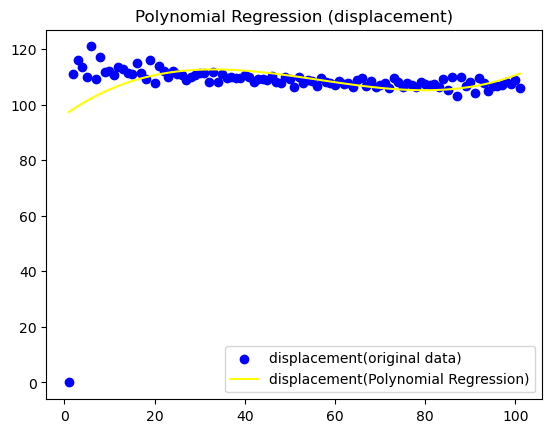

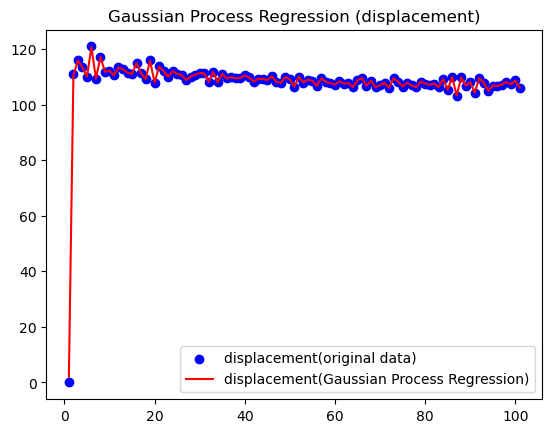

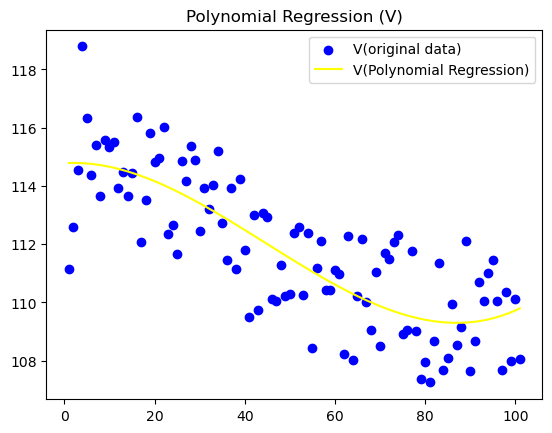

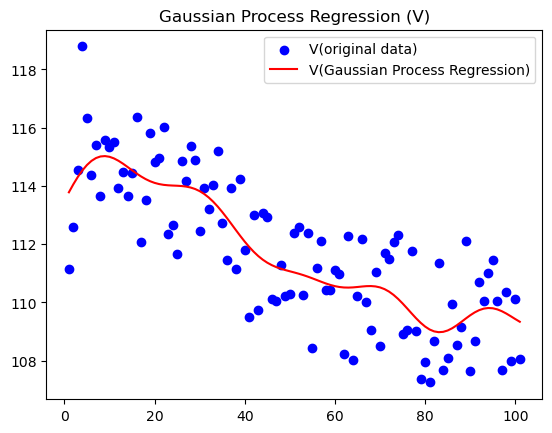

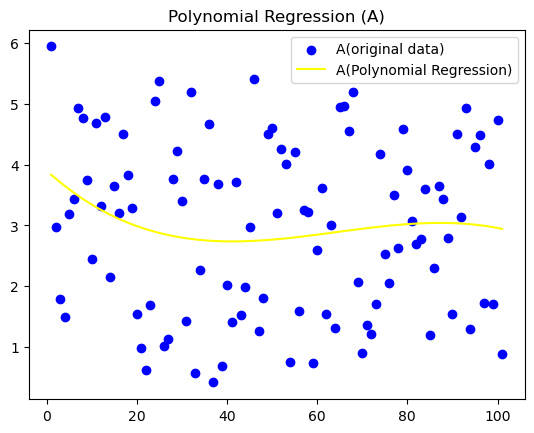

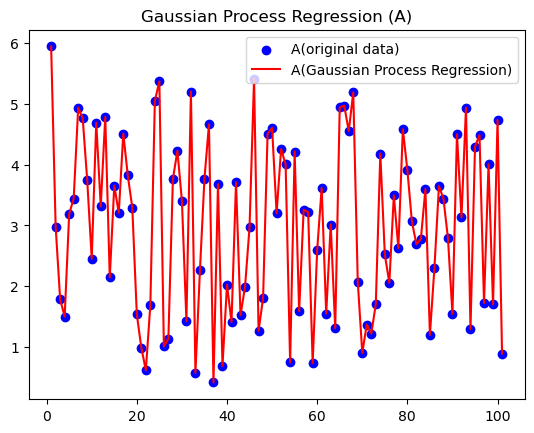

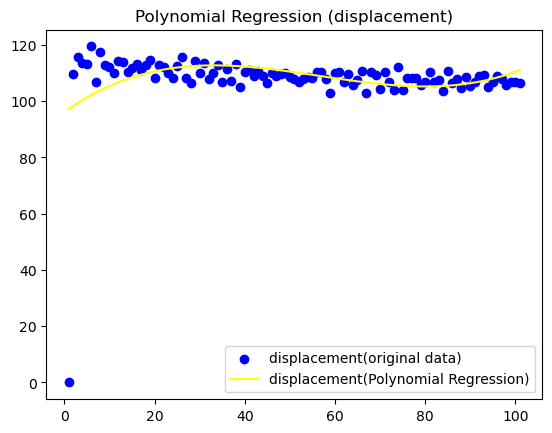

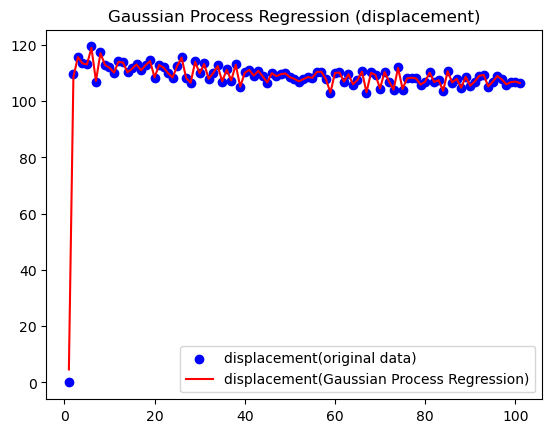

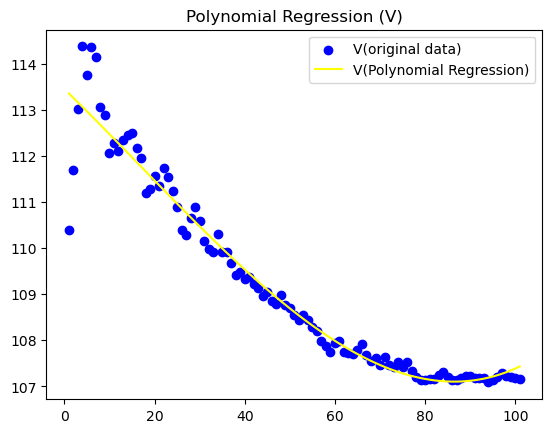

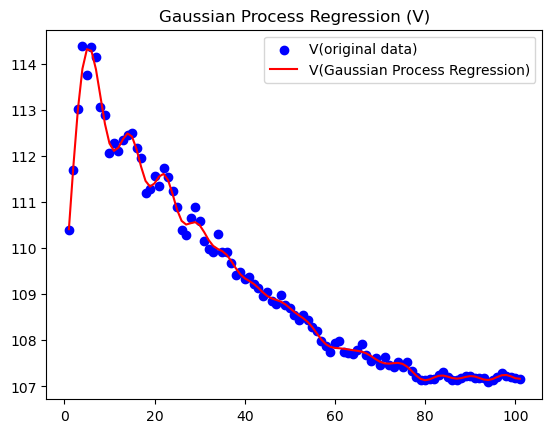

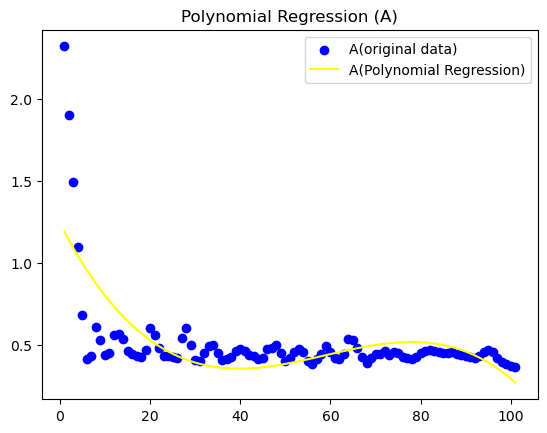

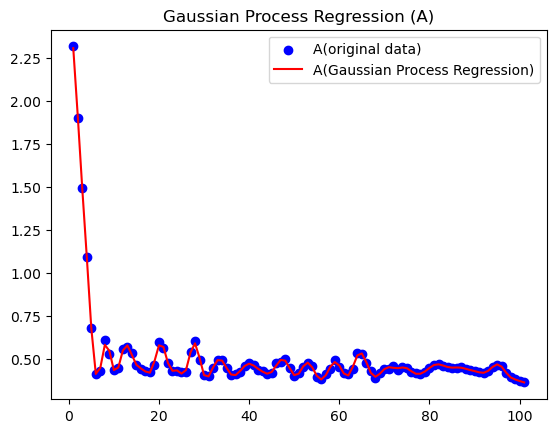

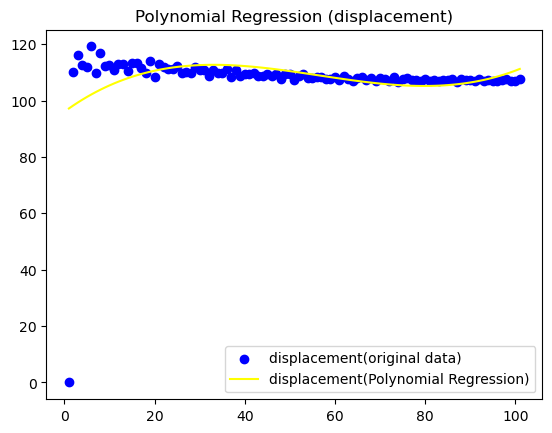

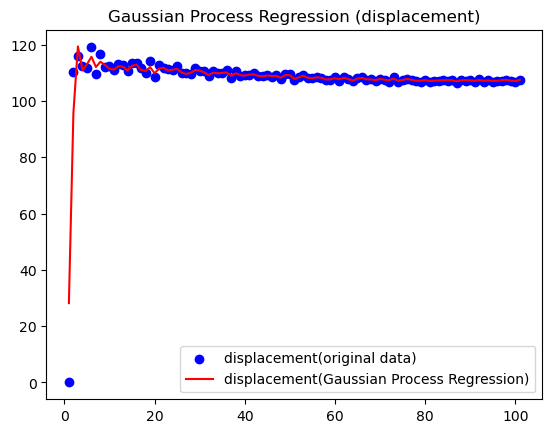

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
import glob
import zipfile
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def read_excel_and_calculate_displacement(file):
    file_extension = file.split('.')[-1]
    if file_extension == 'xlsx':
        engine = 'openpyxl'
    elif file_extension == 'xls':
        engine = 'xlrd'
    else:
        raise ValueError('File extension not supported')
    try:
        table = pd.read_excel(file, engine=engine)
    # except Exception as e:
    #     print(e)
    #     raise ValueError('File extension not supported')
    except zipfile.BadZipFile:
        print(f"Error: BadZipFile for file {file}")
        return None
    table["dx"] = table["x"].diff().fillna(0)
    table["dy"] = table["y"].diff().fillna(0)
    table["dz"] = table["z"].diff().fillna(0)
    table["displacement"] = (table["dx"] ** 2 + table["dy"] ** 2 + table["dz"] ** 2) ** 0.5
    return table

def polynomial_regression_fit(df, degree, target):
    x = df['T'].values.reshape(-1, 1)
    y = df[target].values

    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Polynomial Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")
    
    plt.figure()
    plt.style.use('tableau-colorblind10')
#     plt.style.use('tableau-colorblind10')
#     plt.scatter(x,y,color='blue',label=f"{target}(original data)")
#     plt.plot(np.sort(x,axis=0),model.predict(poly.fit_transform(np.sort(x,axis=0))),color='red',label=f"{target}(Polynomial Regression)")
    plt.scatter(x,y,color='blue',label=f"{target}(original data)")
    plt.plot(np.sort(x,axis=0),model.predict(poly.fit_transform(np.sort(x,axis=0))),color='yellow',label=f"{target}(Polynomial Regression)")
    plt.title(f"Polynomial Regression ({target})")
    plt.legend(loc='best')
#     return model.predict(x_poly)
#     return y_pred, mse, r2
    return y_pred


def gaussian_process_regression_fit(df, target):
    x = df['T'].values.reshape(-1, 1)
    y = df[target].values
    
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

    param_grid = {'kernel__k1__length_scale': np.linspace(0.1, 10, 10),
                  'kernel__k2__noise_level': np.linspace(0.1, 10, 10)}

    model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)

    grid_search.fit(x, y)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")

    y_pred = grid_search.predict(x)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Gaussian Process Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")
#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
#     model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)
#     model.fit(x, y)
#     y_pred = model.predict(x)
#     mse = mean_squared_error(y, y_pred)
#     r2 = r2_score(y, y_pred)
#     print(f"Gaussian Process Regression ({target}): MSE = {mse:.4f}, R-squared = {r2:.4f}")
    plt.figure()
#     plt.style.use('seaborn-dark')
    plt.scatter(x,y,color='blue',label=f"{target}(original data)")
    plt.plot(x, y_pred, color='red', label=f"{target}(Gaussian Process Regression)")
    plt.title(f"Gaussian Process Regression ({target})")
    plt.legend(loc='best')
    
#     return y_pred, mse, r2
    return y_pred


def calculate_deviation(df, y_pred, target):
    deviation = df[target] - y_pred
    return deviation

def output_results(df, file_name):
    df.to_csv(file_name, index=False, encoding='utf-8')

def process_dataframe(df, degree=3):
    for target in ['V', 'A', 'displacement']:
#         y_pred = polynomial_regression_fit(df, degree, target)
#         deviation = calculate_deviation(df, y_pred, target)
#         df[f'{target}_pred'] = y_pred
#         df[f'{target}_deviation'] = deviation
        y_pred_poly = polynomial_regression_fit(df, degree, target)
        y_pred_gpr = gaussian_process_regression_fit(df, target)
        deviation_poly = calculate_deviation(df, y_pred_poly, target)
        deviation_gpr = calculate_deviation(df, y_pred_gpr, target)
        df[f'{target}_pred_poly'] = y_pred_poly
        df[f'{target}_pred_gpr'] = y_pred_gpr
        df[f'{target}_deviation_poly'] = deviation_poly
        df[f'{target}_deviation_gpr'] = deviation_gpr
        mse_poly = mean_squared_error(df[target], y_pred_poly)
        mse_gpr = mean_squared_error(df[target], y_pred_gpr)
        if mse_gpr < mse_poly:
            df[f'{target}_pred'] = y_pred_gpr
            df[f'{target}_deviation'] = deviation_gpr
        else:
            df[f'{target}_pred'] = y_pred_poly
            df[f'{target}_deviation'] = deviation_poly
            
    output_file_name = f"{file.replace('.xlsx', '')}_processed.csv"
    print(f"Saving processed data to {output_file_name}")
    output_results(df, output_file_name)
    return df

data_files = glob.glob("./*.xlsx")
degree = 3

for file in data_files:
#   if file.startswith('instrument'):
    input_df = read_excel_and_calculate_displacement(file)
    if input_df is not None:
        output_df = process_dataframe(input_df, degree)
        print(f'{file} Done!')
        print("----------------------------------------------------------------------------------------")
#             output_file = file.replace('.xlsx', '_output.csv')
#             output_results(output_df, output_file)
#             print(file)
print(f"Complete all processing steps.")

输出表：

| 字段 | 含义 |
| --- | --- |
| T | 时间 |
| x | 物体在x轴上的位置 |
| y | 物体在y轴上的位置 |
| z | 物体在z轴上的位置 |
| Vx | 物体在x轴上的速度 |
| Vy | 物体在y轴上的速度 |
| Vz | 物体在z轴上的速度 |
| V | 物体的速度 |
| Ax | 物体在x轴上的加速度 |
| Ay | 物体在y轴上的加速度 |
| Az | 物体在z轴上的加速度 |
| A | 物体的加速度 |
| dx | x轴上的位移变化 |
| dy | y轴上的位移变化 |
| dz | z轴上的位移变化 |
| displacement | 物体的位移 |
| V_pred_poly | 用多项式回归模型拟合的物体速度 |
| V_pred_gpr | 用高斯过程回归模型拟合的物体速度 |
| V_deviation_poly | 多项式回归模型对物体速度的拟合偏差 |
| V_deviation_gpr | 高斯过程回归模型对物体速度的拟合偏差 |
| V_pred | 综合多项式回归模型和高斯过程回归模型的拟合物体速度 |
| V_deviation | 多项式回归模型和高斯过程回归模型对物体速度的综合拟合偏差 |
| A_pred_poly | 用多项式回归模型拟合的物体加速度 |
| A_pred_gpr | 用高斯过程回归模型拟合的物体加速度 |
| A_deviation_poly | 多项式回归模型对物体加速度的拟合偏差 |
| A_deviation_gpr | 高斯过程回归模型对物体加速度的拟合偏差 |
| A_pred | 综合多项式回归模型和高斯过程回归模型的拟合物体加速度 |
| A_deviation | 多项式回归模型和高斯过程回归模型对物体加速度的综合拟合偏差 |
| displacement_pred_poly | 用多项式回归模型拟合的物体位移 |
| displacement_pred_gpr | 用高斯过程回归模型拟合的物体位移 |
| displacement_deviation_poly | 多项式回归模型对物体位移的拟合偏差 |
| displacement_deviation_gpr | 高斯过程回归模型对物体位移的拟合偏差 |
| displacement_pred | 综合多项式回归模型和高斯过程回归模型的拟合物体位移 |
| displacement_deviation | 多项式回归模型和高斯过程回归模型对物体位移的综合拟合偏差 |